<a href="https://colab.research.google.com/github/BeeramVineethReddy/Geno_Intern/blob/master/Copy_of_Trail_7(BILSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!unzip -qq /gdrive/MyDrive/StandardNames.zip -d /content
#/content/drive/MyDrive/StandardNames.zip

'''
!unzip -qq /gdrive/MyDrive/ResearchNotebooks/Dataset/Tubule_2/StandardNames.zip -d /content
'''

Mounted at /gdrive


'\n!unzip -qq /gdrive/MyDrive/ResearchNotebooks/Dataset/Tubule_2/StandardNames.zip -d /content\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import sys
import random
from skimage.io import imread,imshow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

from sklearn.model_selection import train_test_split

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input,add, multiply
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint,EarlyStopping
from keras.layers import concatenate, core, Dropout
from keras.models import Model

from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers.core import Lambda
import keras.backend as K

seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

In [ ]:
x = []; y = []
images = sorted(os.listdir('/content/image'))
masks = sorted(os.listdir('/content/mask'))
for image in images:
  img = cv2.imread('/content/image/' + image)
  x.append(img)
  x.append(cv2.flip(img, 0))
  x.append(cv2.flip(img, -1))
  x.append(cv2.flip(img, 1))
  msk = cv2.imread('/content/mask/'+ image[:-4] + '_anno.png',0).reshape(256,256,1)
  y.append(msk)
  y.append(cv2.flip(msk, 0).reshape(256,256,1))
  y.append(cv2.flip(msk, -1).reshape(256,256,1))
  y.append(cv2.flip(msk, 1).reshape(256,256,1))
x = np.asarray(x)/255; y = np.asarray(y)/255

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1 - train_ratio, random_state = 42, shuffle = True)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 42, shuffle = True) 
print('Data Split!')
print(len(x_train),len(x_test), len(x_valid))
print(x_train[0].shape, y_train[0].shape)

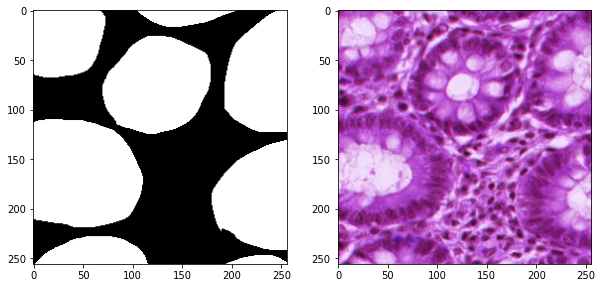

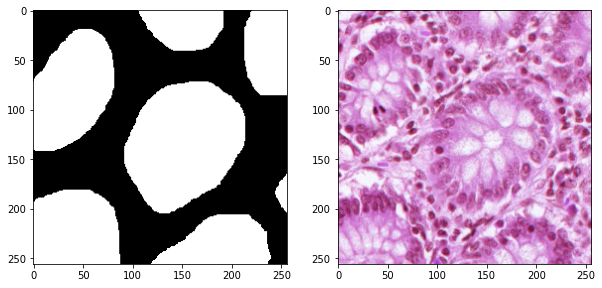

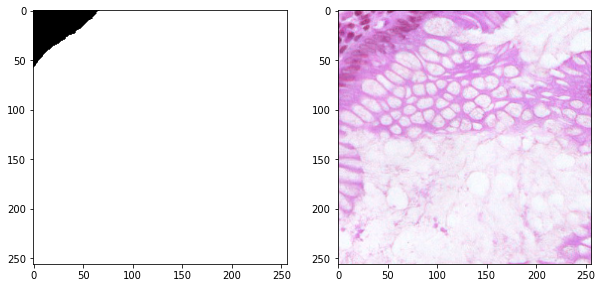

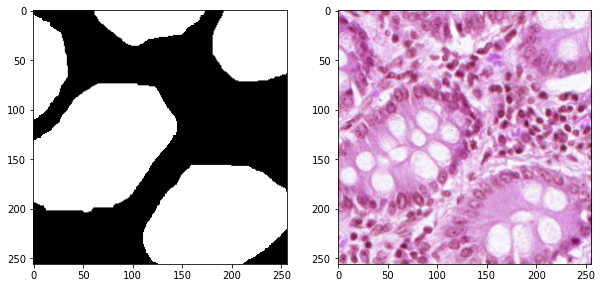

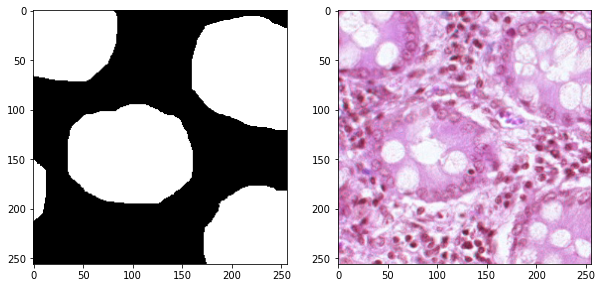

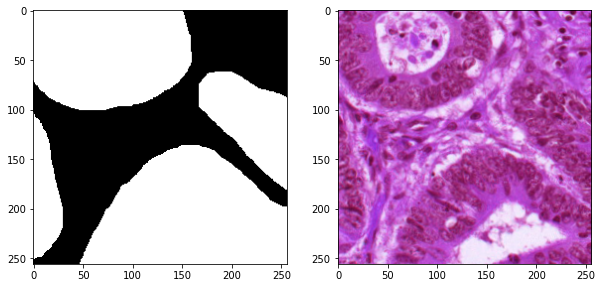

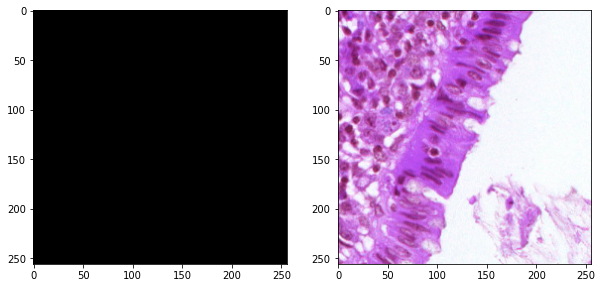

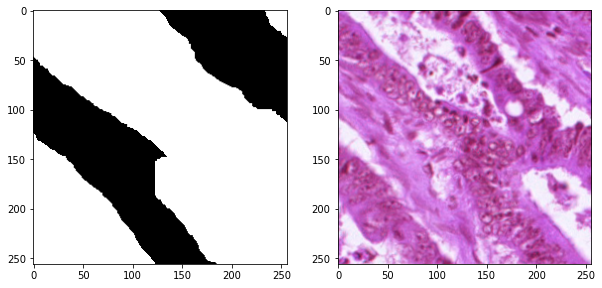

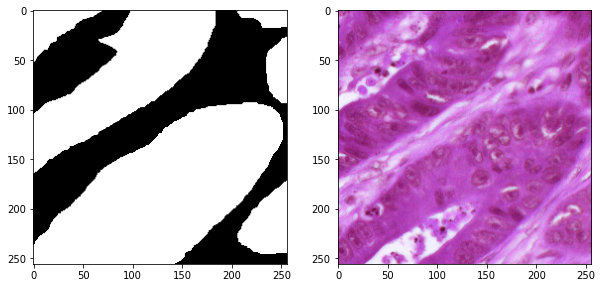

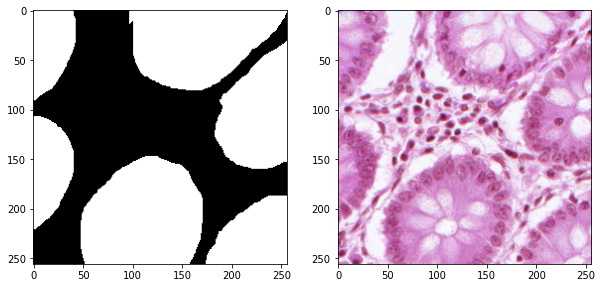

In [ ]:
for i in range(10,20):
  fig=plt.figure(figsize=(10,10))
  a=fig.add_subplot(1,2,1)
  a.imshow(y_train[i].reshape(256,256),cmap="gray")
  a=fig.add_subplot(1,2,2)  
  a.imshow(x_train[i])

In [ ]:
from __future__ import division
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras.optimizers import *
from keras.layers import *        
    

In [ ]:
def BCDU_net_D3(input_size = (256,256,3)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs = inputs, outputs = conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])    
    return model

def BCDU_net_D1(input_size = (256,256,3)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
   
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv4_1)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs = inputs, outputs = conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])    
    return model
    
model = BCDU_net_D3()
model.summary()
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
results = model.fit(x_train,y_train,validation_data=(x_valid,y_valid),batch_size=16, epochs=100, callbacks=[
    ModelCheckpoint('model_att.h5', save_best_only=True, monitor='val_mean_io_u', mode='max')                                                                                                            
])

Epoch 1/500


ResourceExhaustedError: ignored

In [ ]:
model.save('/gdrive/MyDrive/ResearchNotebooks/Trail_6_att.h5')

In [ ]:
# graph of iou vs epoch
plt.plot(results.history['mean_io_u'])
plt.plot(results.history['val_mean_io_u'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# graph of loss vs epoch
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#function for drawing contours using edges derived from mask
def contour_img(image,mask,flag):
    if(flag==0):
        color=(0,255,0) #flag 0 indicates the edges derived from actual mask denoted in green color
        thickness=5
    elif(flag==1):
        color=(255,0,0) #flag 1 indicates the edges derived from predicted mask denoted in red color
        thickness=3
    mask=mask.astype(np.uint8)
    edge=cv2.Canny(mask,100,200)
    contours, hierarchy = cv2.findContours(edge,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
    #cv.CHAIN_APPROX_SIMPLE does. 
    #It removes all redundant points and compresses the contour, thereby saving memory.


    cv2.drawContours(image, contours, -1,color, thickness)
    return image
#calculating IOU score
def mean_iou(mask, pred):
    intersection = np.logical_and(mask,pred)
    union = np.logical_or(mask, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    if(np.sum(union)==0):
        return 100
    return iou_score*100

In [ ]:
X_Test = np.copy(x_valid)
Y_Test = np.copy(y_valid)

#displaying output
index=0
for image in X_Test[:40]:
    test=image.reshape(1,256,256,3)
    mask=Y_Test[index]
    mask=mask.astype(np.uint8)
    mask=mask*255
    img = X_Test[index].copy()
    image1=contour_img(X_Test[index],mask,0)
    
    pred=model.predict(test)
    pred=pred.reshape(256,256)
    ret,pred_mask = cv2.threshold(pred,0.9,1,cv2.THRESH_BINARY)
    pred_mask=pred_mask*255
    pred_mask=pred_mask.astype(np.uint8)
    image2=contour_img(image1,pred_mask,1)
    mask=mask/255
    pred_mask=pred_mask/255
    fig=plt.figure(figsize=(20,20))
    a=fig.add_subplot(1,4,1)
    a.title.set_text('Ground Truth')
    
    mask=mask.reshape(256,256)
    a.imshow(mask.reshape(256,256),cmap="gray")
    a=fig.add_subplot(1,4,2)
    a.title.set_text('Overlay')
    
    a.imshow(image)
    a=fig.add_subplot(1,4,3)
    a.title.set_text('Input')
    
    a.imshow(x_test[index])
    a=fig.add_subplot(1,4,4)
    a.title.set_text('Predicted')
    
    a.imshow(pred,cmap='gray')
    index=index+1 